#Download dataset and convert to COCO 2017 format

In [ ]:
# clone detr
!git clone https://github.com/facebookresearch/detr.git
# !pip install pytorch pytorch torchvision

# download data
%cd /content/
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar
!rm VOCtrainval_11-May-2012.tar


Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

In [ ]:
# This is to get all the annotation files for data format conversion.
import os
anno_root = "/content/VOCdevkit/VOC2012/Annotations"
xmls = [f for f in os.listdir(anno_root) if f.endswith(".xml")]

with open("anno_path_list.txt", "w") as f:
  for xml in xmls:
    f.write(os.path.join(anno_root, xml)+"\n")


In [ ]:
# align the labels in VOC dataset to label index in COCO dataset.
COCO_CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


TRANSLATE = {
    "airplane": "aeroplane",
    "dining table": "diningtable",
    "motorcycle": "motorbike",
    "potted plant": "pottedplant",
    "couch": "sofa",
    "tv": "tvmonitor",
}


label_path = "coco_labels.txt"

i_empty = 0
with open(label_path, "w") as f:
    for i, label in enumerate(COCO_CLASSES[1:]):
        if label == "N/A":
            label = f"empty{i_empty}"
        if label in TRANSLATE:
            label = TRANSLATE[label]
        f.write(f"{label}\n")

In [ ]:
!mkdir VOC_coco_format
!mkdir VOC_coco_format/train2017/
!mkdir VOC_coco_format/val2017/
!mkdir VOC_coco_format/annotations/

In [ ]:
# Generate .json file from all the xml annotation files
# modify from https://github.com/yukkyo/voc2coco/blob/master/voc2coco.py
import os
import json
import xml.etree.ElementTree as ET
from typing import Dict, List
from tqdm import tqdm


def get_label2id(labels_path: str) -> Dict[str, int]:
    """id is 1 start"""
    with open(labels_path, 'r') as f:
        labels_str = f.read().split("\n")
    labels_ids = list(range(1, len(labels_str)+1))
    return dict(zip(labels_str, labels_ids))


def get_annpaths(ann_dir_path: str = None,
                 ann_ids_path: str = None,
                 ext: str = '',
                 annpaths_list_path: str = None) -> List[str]:
    # If use annotation paths list
    if annpaths_list_path is not None:
        with open(annpaths_list_path, 'r') as f:
            ann_paths = f.read().split()
        return ann_paths

    # If use annotaion ids list
    ext_with_dot = '.' + ext if ext != '' else ''
    with open(ann_ids_path, 'r') as f:
        ann_ids = f.read().split()
    ann_paths = [os.path.join(ann_dir_path, aid+ext_with_dot) for aid in ann_ids]
    return ann_paths


def get_img_ids_from_ann_paths(ann_paths: List[str]):
    img_ids = [os.path.splitext(os.path.basename(ap))[0] for ap in ann_paths]
    num_ids = list(range(1, len(img_ids)+1))
    return dict(zip(img_ids, num_ids))


def get_image_info(annotation_root, img_id_dict=None):
    global id_set
    path = annotation_root.findtext('path')
    if path is None:
        filename = annotation_root.findtext('filename')
    else:
        filename = os.path.basename(path)
    img_name = os.path.basename(filename)
    img_id = os.path.splitext(img_name)[0]
    if img_id_dict is not None:
        assert img_id in img_id_dict, f"Error: {img_id} is not in img_id_dict !"
        img_id = img_id_dict[img_id]


    size = annotation_root.find('size')
    width = int(size.findtext('width'))
    height = int(size.findtext('height'))

    image_info = {
        'file_name': filename,
        'height': height,
        'width': width,
        'id': img_id
    }
    return image_info


def get_coco_annotation_from_obj(obj, label2id):
    label = obj.findtext('name')
    assert label in label2id, f"Error: {label} is not in label2id !"
    category_id = label2id[label]
    bndbox = obj.find('bndbox')
    xmin = int(float(bndbox.findtext('xmin'))) - 1
    ymin = int(float(bndbox.findtext('ymin'))) - 1
    xmax = int(float(bndbox.findtext('xmax')))
    ymax = int(float(bndbox.findtext('ymax')))
    assert xmax > xmin and ymax > ymin, f"Box size error !: (xmin, ymin, xmax, ymax): {xmin, ymin, xmax, ymax}"
    o_width = xmax - xmin
    o_height = ymax - ymin
    ann = {
        'area': o_width * o_height,
        'iscrowd': 0,
        'bbox': [xmin, ymin, o_width, o_height],
        'category_id': category_id,
        'ignore': 0,
        'segmentation': []  # This script is not for segmentation
    }
    return ann


def convert_xmls_to_cocojson(annotation_paths: List[str],
                             label2id: Dict[str, int],
                             output_jsonpath: str,
                             extract_num_from_imgid: bool = True):
    output_json_dict = {
        "images": [],
        "type": "instances",
        "annotations": [],
        "categories": []
    }
    bnd_id = 1  # START_BOUNDING_BOX_ID, TODO input as args ?
    print('Start converting !')

    if extract_num_from_imgid:
        img_id_dict = get_img_ids_from_ann_paths(ann_paths=annotation_paths)
    else:
        img_id_dict = None

    for a_path in tqdm(annotation_paths):
        # Read annotation xml
        ann_tree = ET.parse(a_path)
        ann_root = ann_tree.getroot()

        img_info = get_image_info(annotation_root=ann_root,
                                  img_id_dict=img_id_dict)
        img_id = img_info['id']
        output_json_dict['images'].append(img_info)

        for obj in ann_root.findall('object'):
            ann = get_coco_annotation_from_obj(obj=obj, label2id=label2id)
            ann.update({'image_id': img_id, 'id': bnd_id})
            output_json_dict['annotations'].append(ann)
            bnd_id = bnd_id + 1

    for label, label_id in label2id.items():
        category_info = {'supercategory': 'none', 'id': label_id, 'name': label}
        output_json_dict['categories'].append(category_info)

    with open(output_jsonpath, 'w') as f:
        output_json = json.dumps(output_json_dict)
        f.write(output_json)


def main():
    label2id = get_label2id(labels_path="coco_labels.txt")
    ann_paths = get_annpaths(
        ann_dir_path=None,
        ann_ids_path=None,
        ext="xml",
        annpaths_list_path="anno_path_list.txt"
    )
    convert_xmls_to_cocojson(
        annotation_paths=ann_paths,
        label2id=label2id,
        output_jsonpath="VOC_coco_format/output.json",
        extract_num_from_imgid=True
    )


if __name__ == '__main__':
    main()


Start converting !


100%|██████████| 17125/17125 [00:01<00:00, 9422.26it/s]


In [ ]:
!cp VOC_coco_format/output.json VOC_coco_format/annotations/instances_train2017.json
!cp VOC_coco_format/output.json VOC_coco_format/annotations/instances_val2017.json
!cp /content/VOCdevkit/VOC2012/JPEGImages/* /content/VOC_coco_format/train2017/
!cp /content/VOCdevkit/VOC2012/JPEGImages/* /content/VOC_coco_format/val2017/

# Finetune the model

In [ ]:
!python '/content/detr/main.py' --batch_size 4   --resume https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth  --coco_path '/content/VOC_coco_format'  --output_dir './output/' --lr 1e-5 --lr_backbone 1e-6 --epochs 2

Not using distributed mode
git:
  sha: 29901c51d7fe8712168b8d0d64351170bc0f83e0, status: has uncommited changes, branch: main

Namespace(lr=1e-05, lr_backbone=1e-06, batch_size=4, weight_decay=0.0001, epochs=2, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco', coco_path='/content/VOC_coco_format', coco_panoptic_path=None, remove_difficult=False, output_dir='./output/', device='cuda', seed=42, resume='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.

# Inference

In [ ]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [ ]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=False)
# checkpoint = torch.load('output/checkpoint.pth') # to run inference on finetuned model
checkpoint = torch.load('/content/detr-r50-e632da11.pth') # to run inference on pre trained model
model.load_state_dict(checkpoint['model'])
model.eval()


Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
<ipython-input-13-ded49d9a2b8d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.lo

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

# Viusalize the results

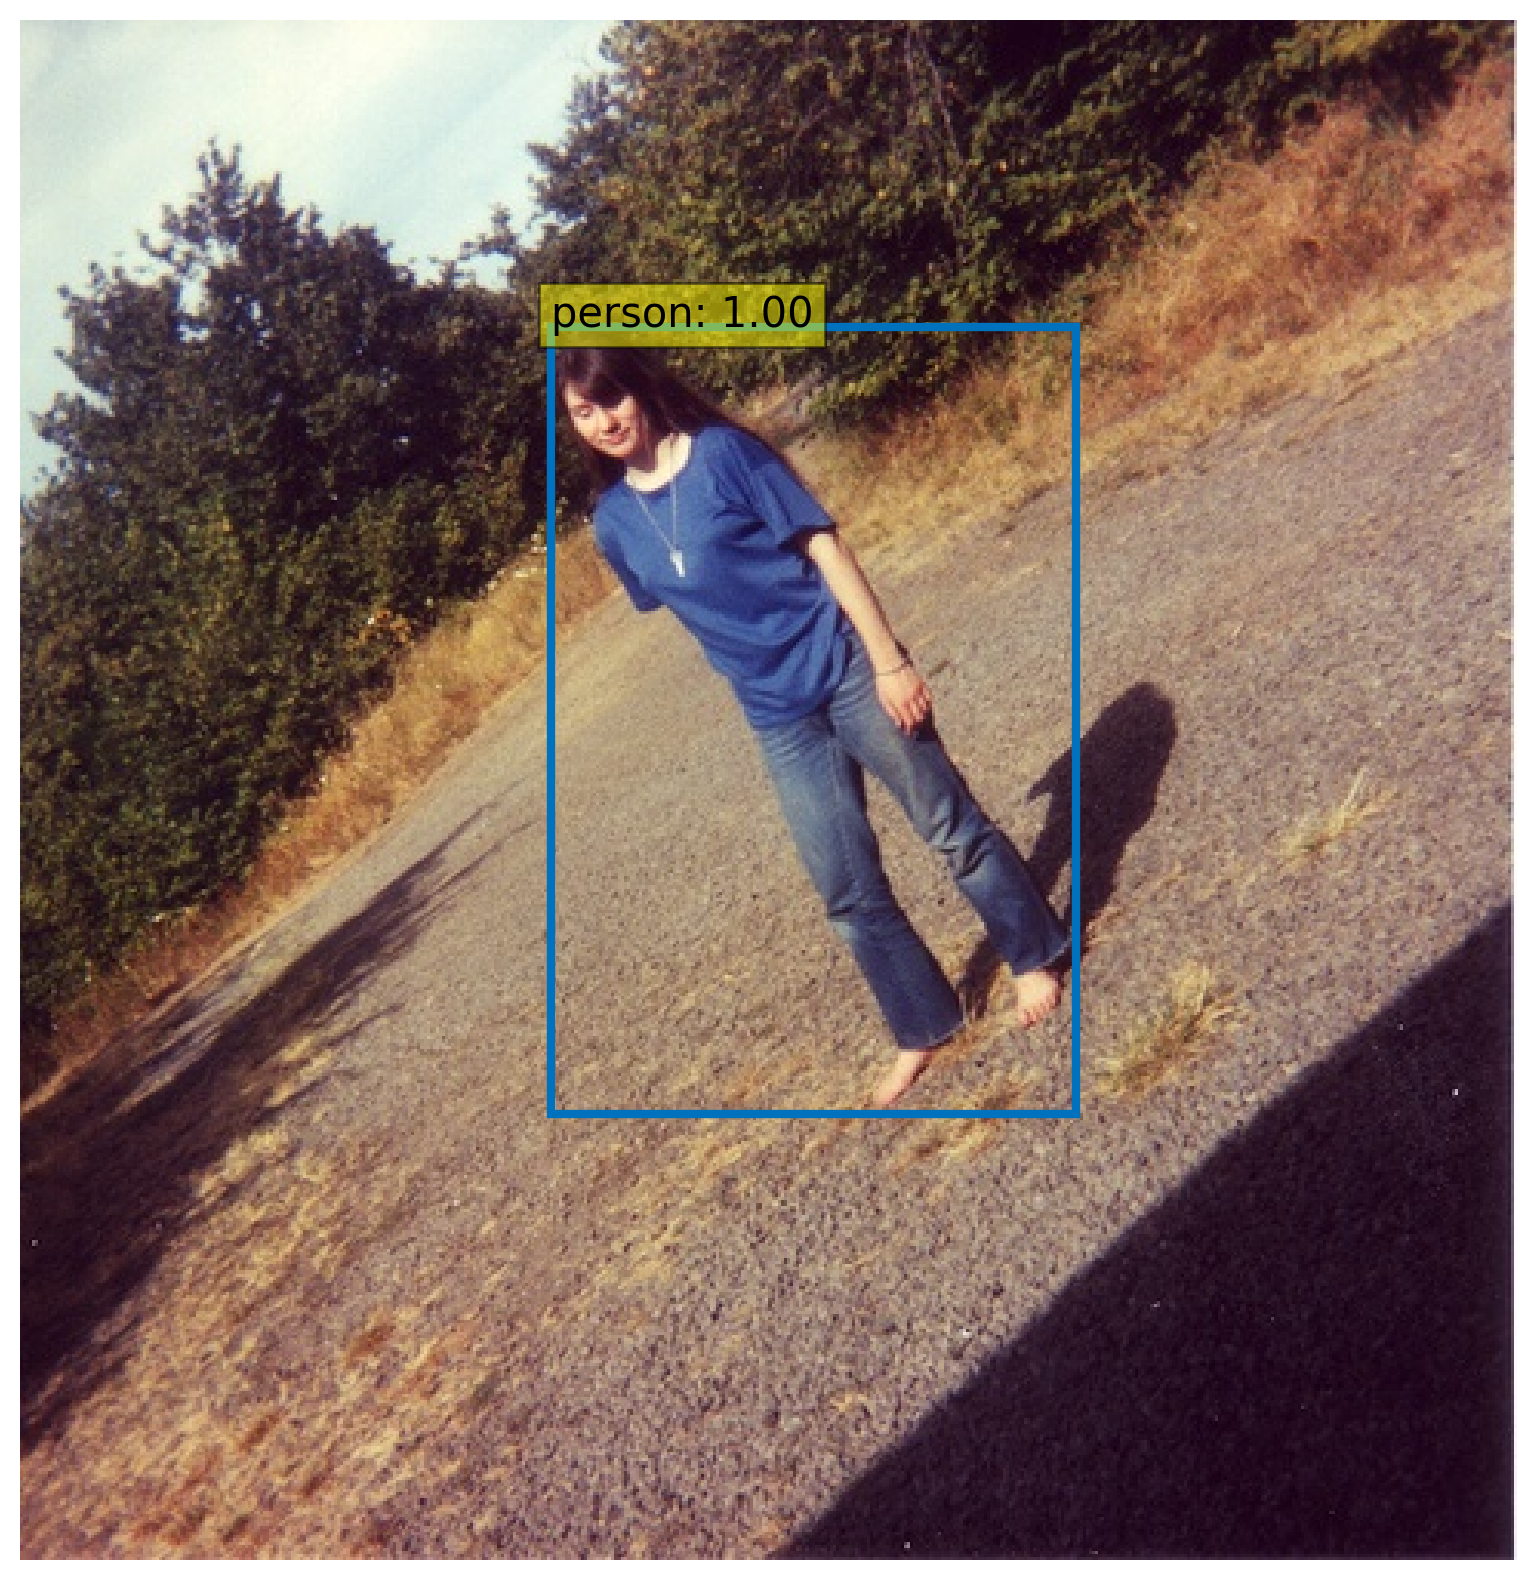

In [ ]:
url = '/content/VOC_coco_format/val2017/2007_000027.jpg'
im = Image.open(url)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

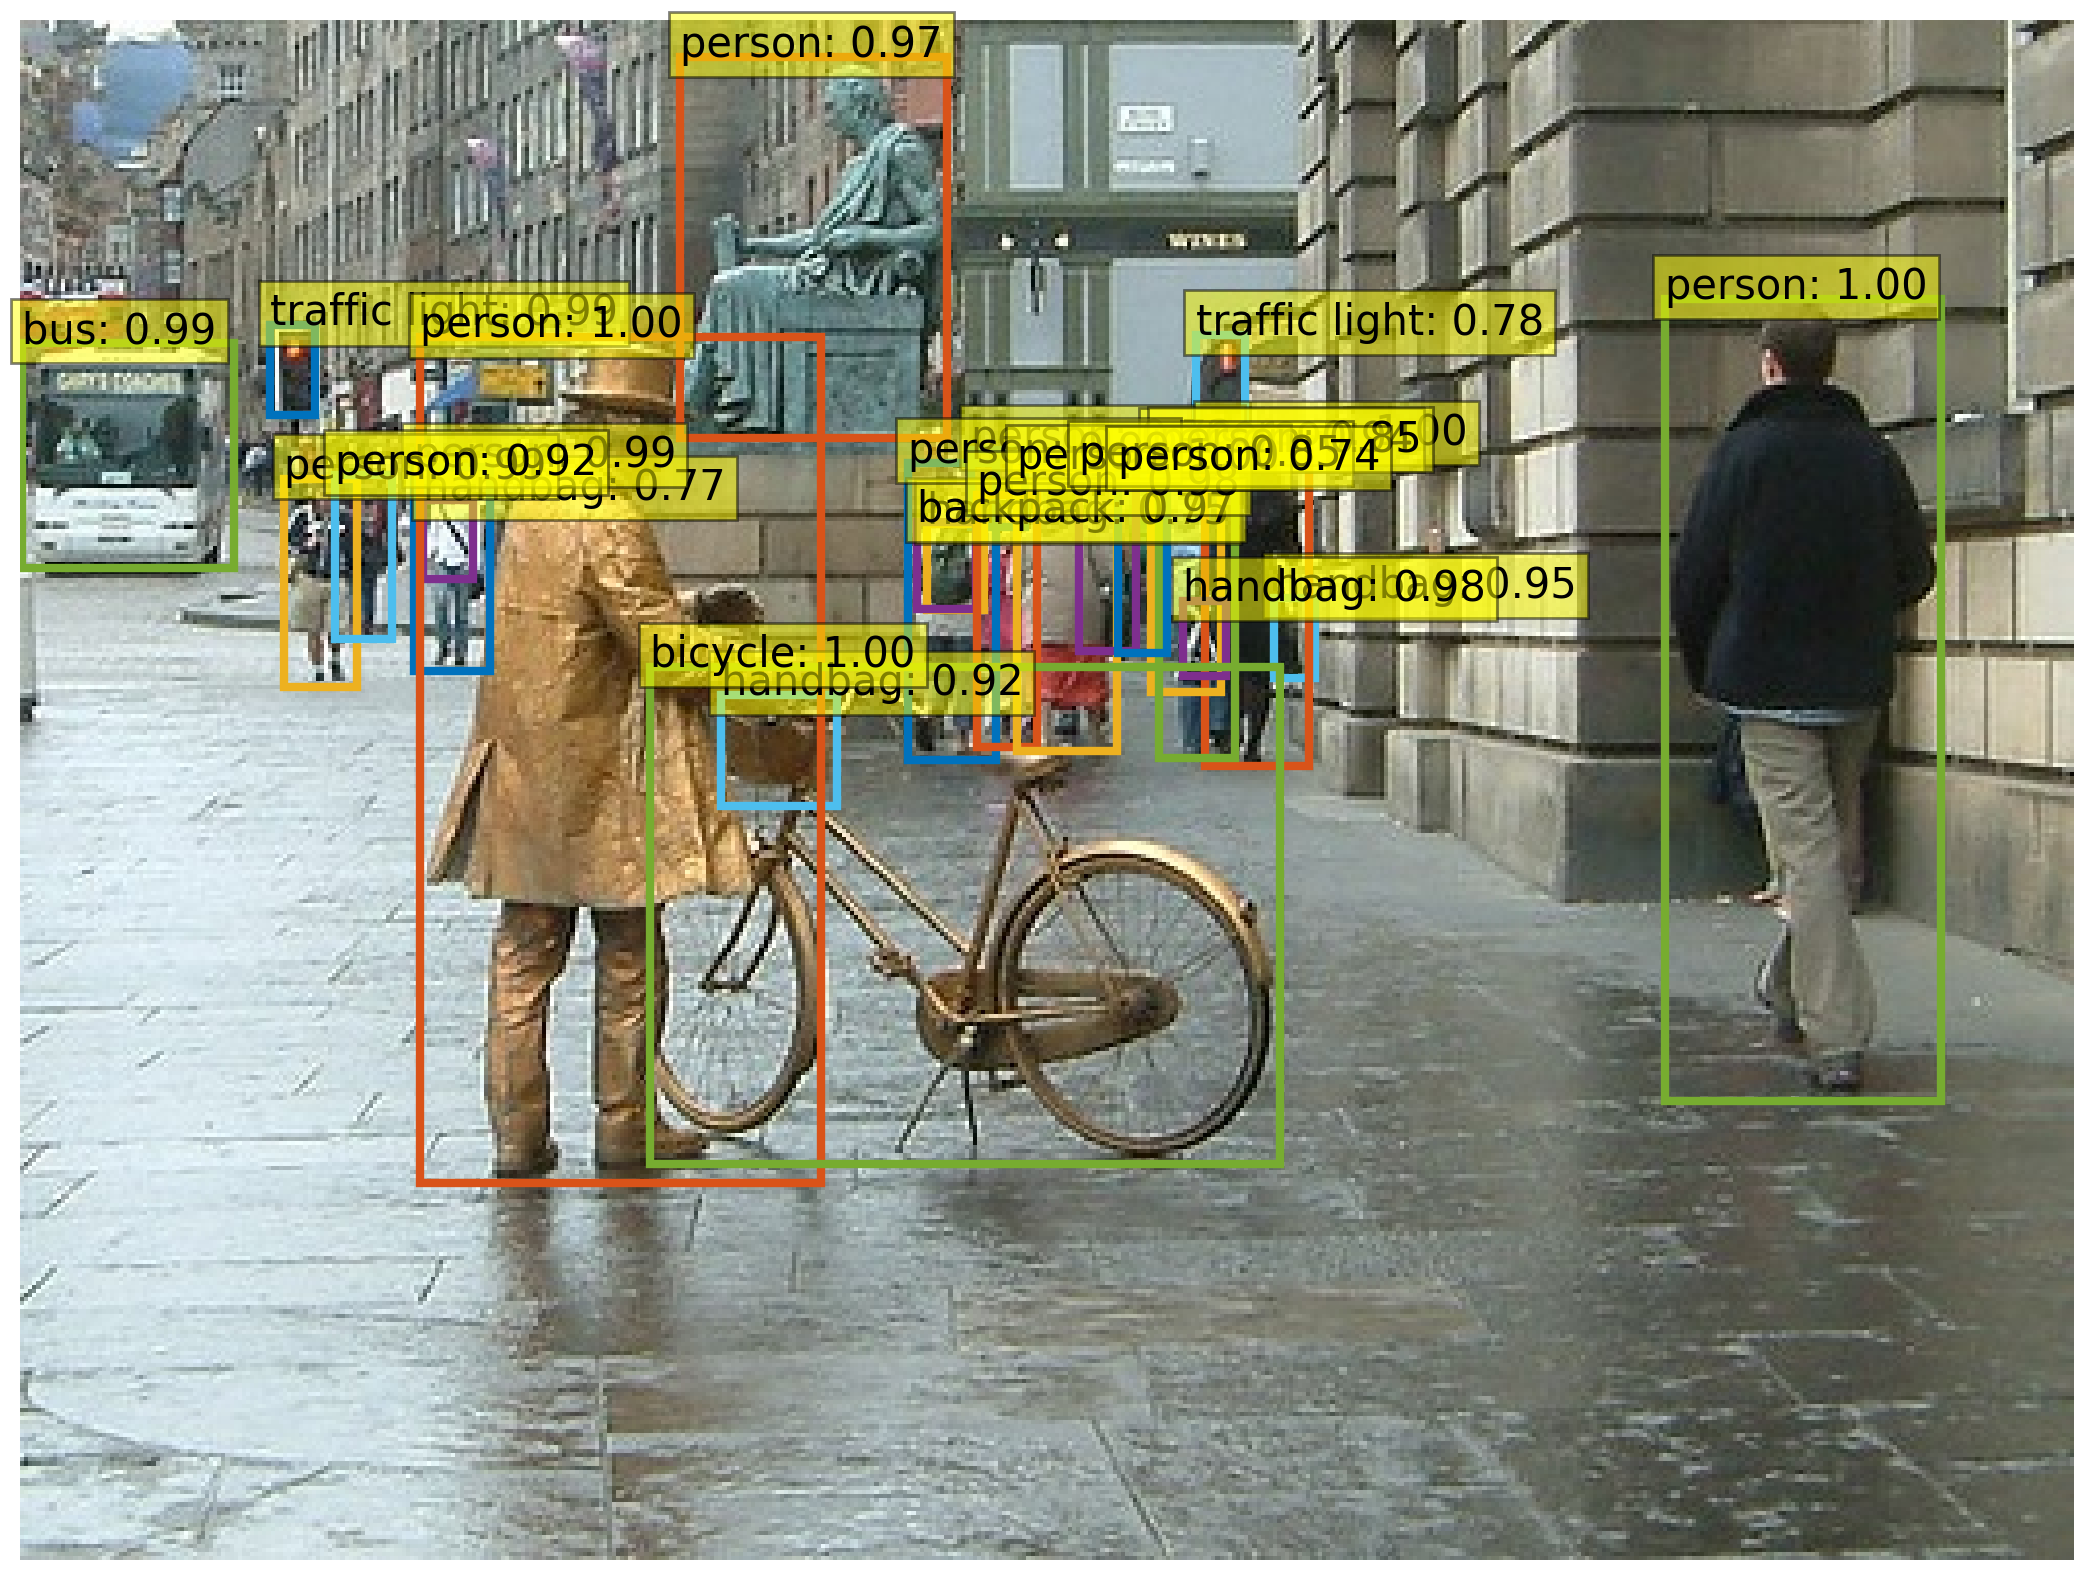

In [ ]:
url = '/content/VOC_coco_format/val2017/2007_000793.jpg'
im = Image.open(url)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

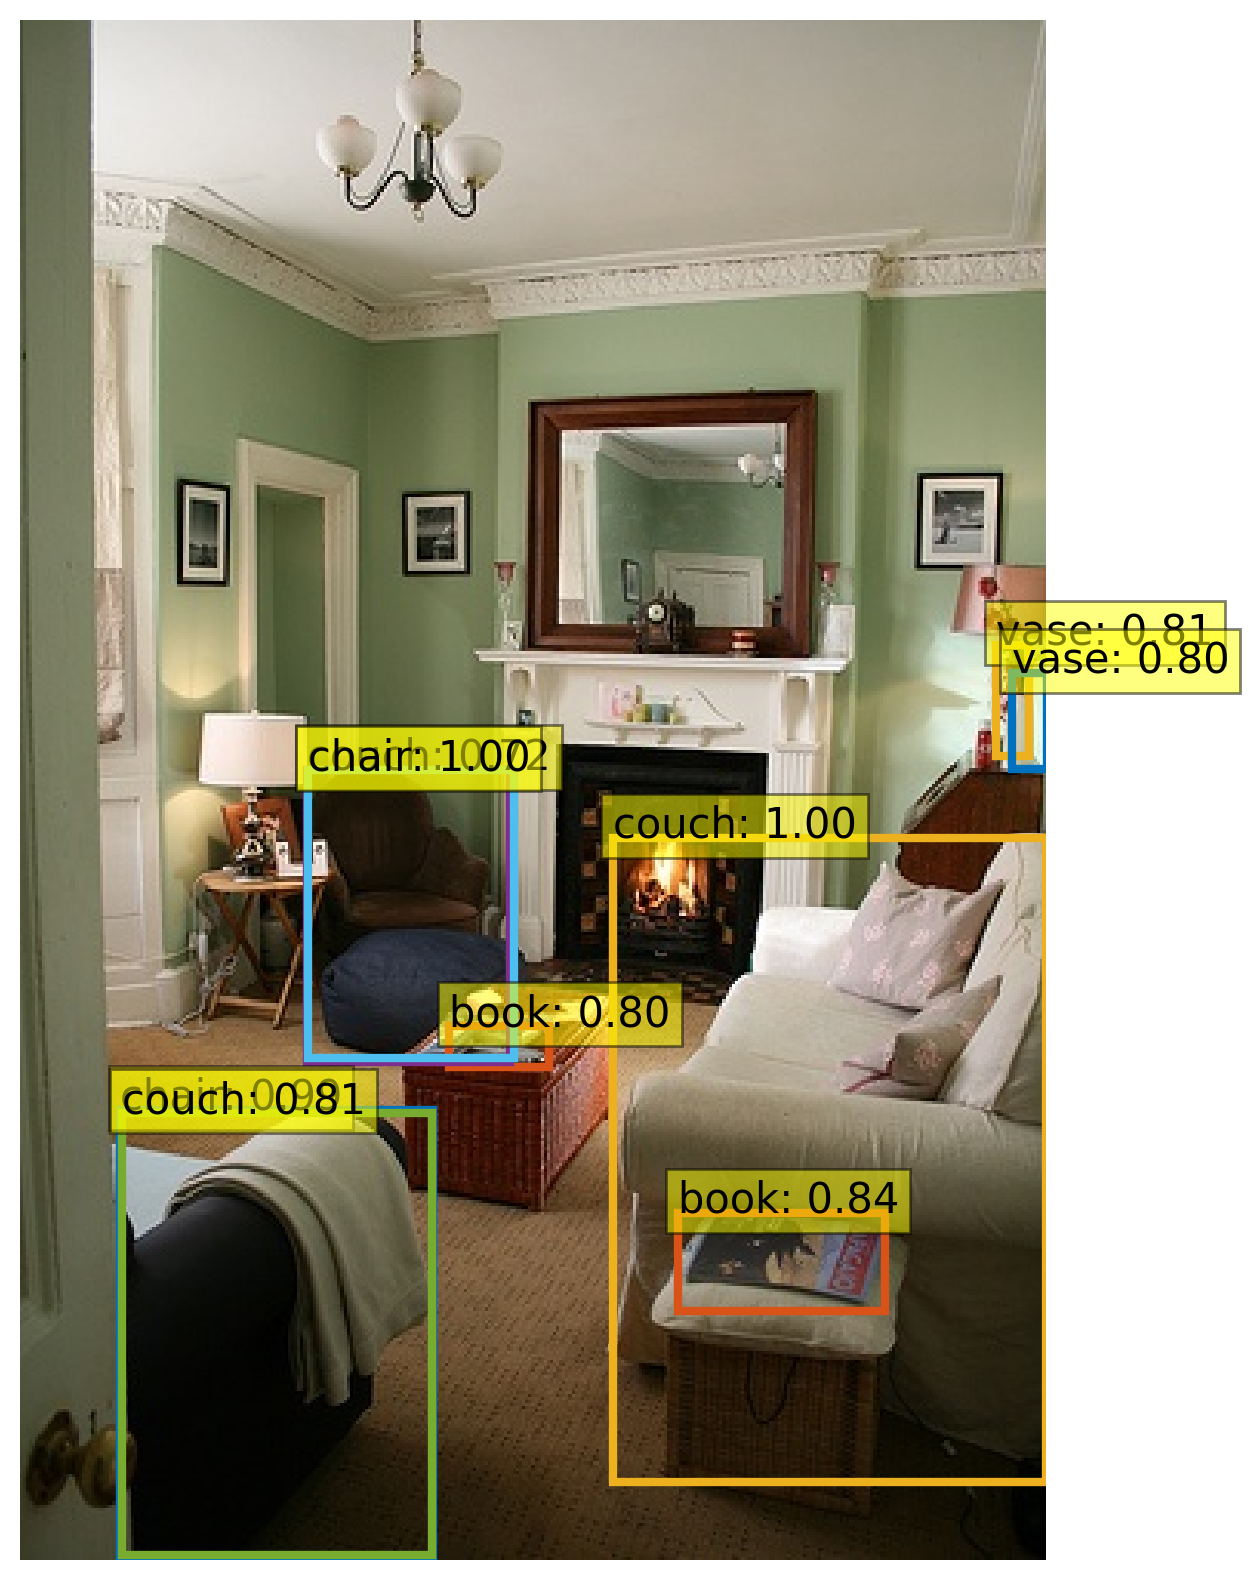

In [ ]:
url = '/content/VOC_coco_format/val2017/2007_000804.jpg'
im = Image.open(url)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

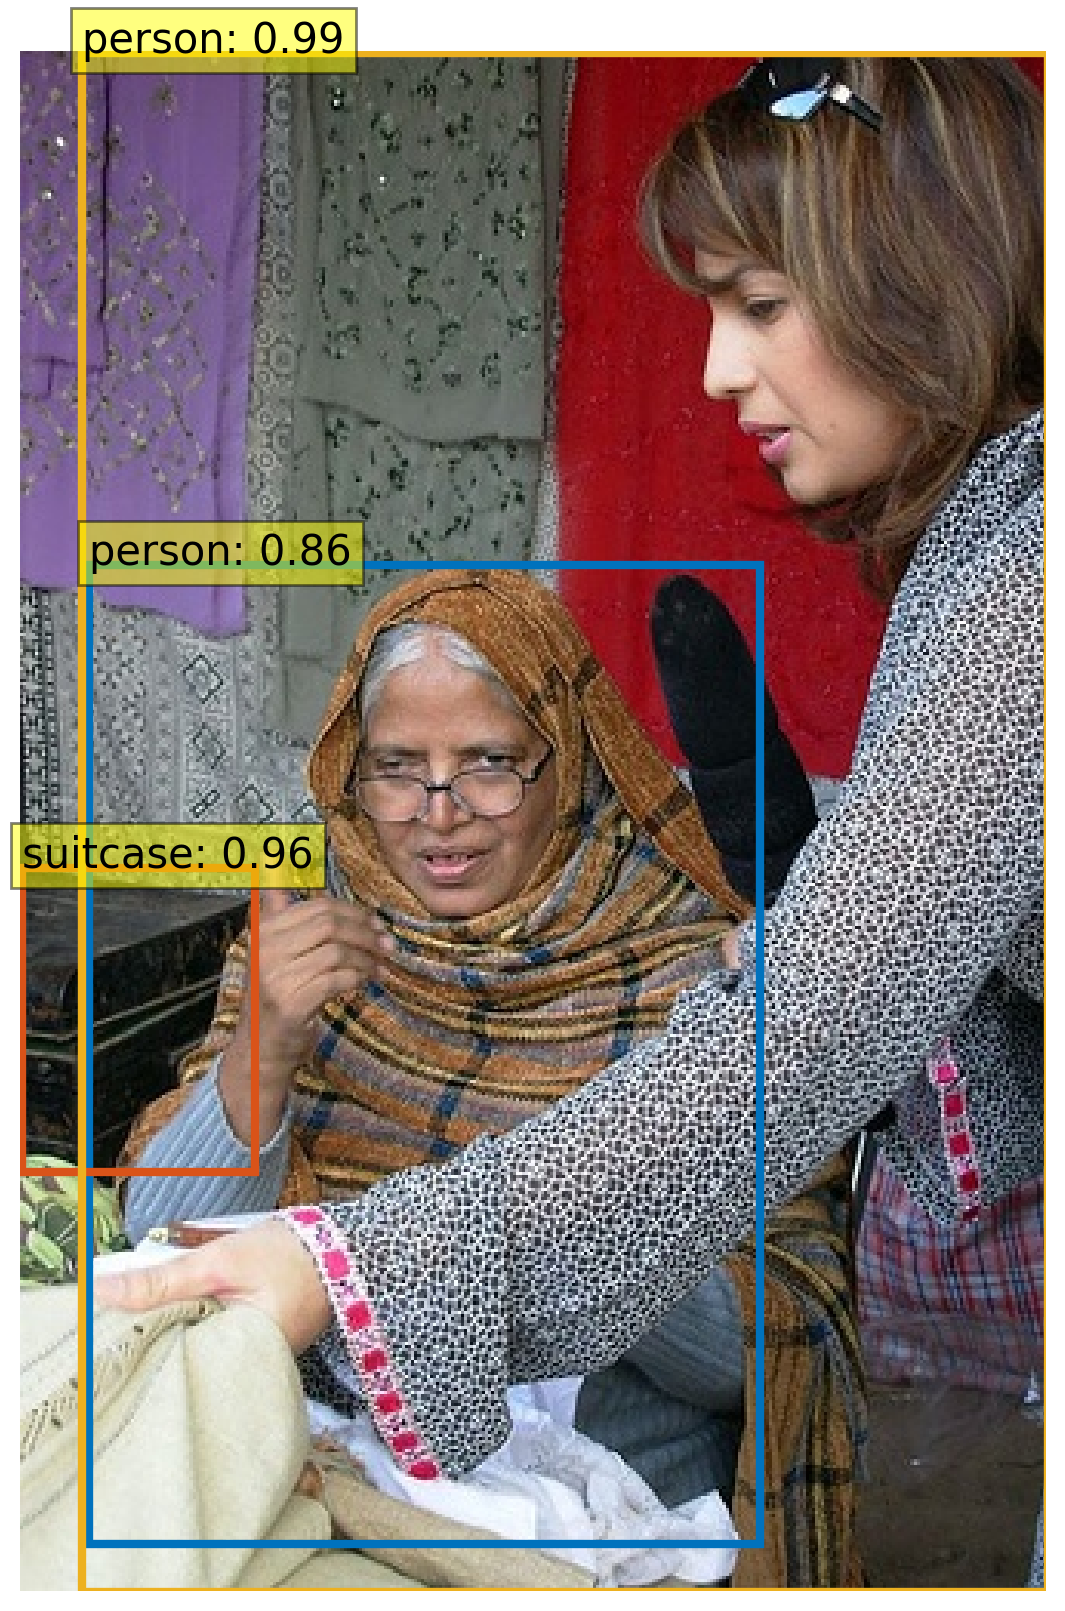

In [ ]:
url = '/content/VOC_coco_format/val2017/2007_003091.jpg'
im = Image.open(url)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

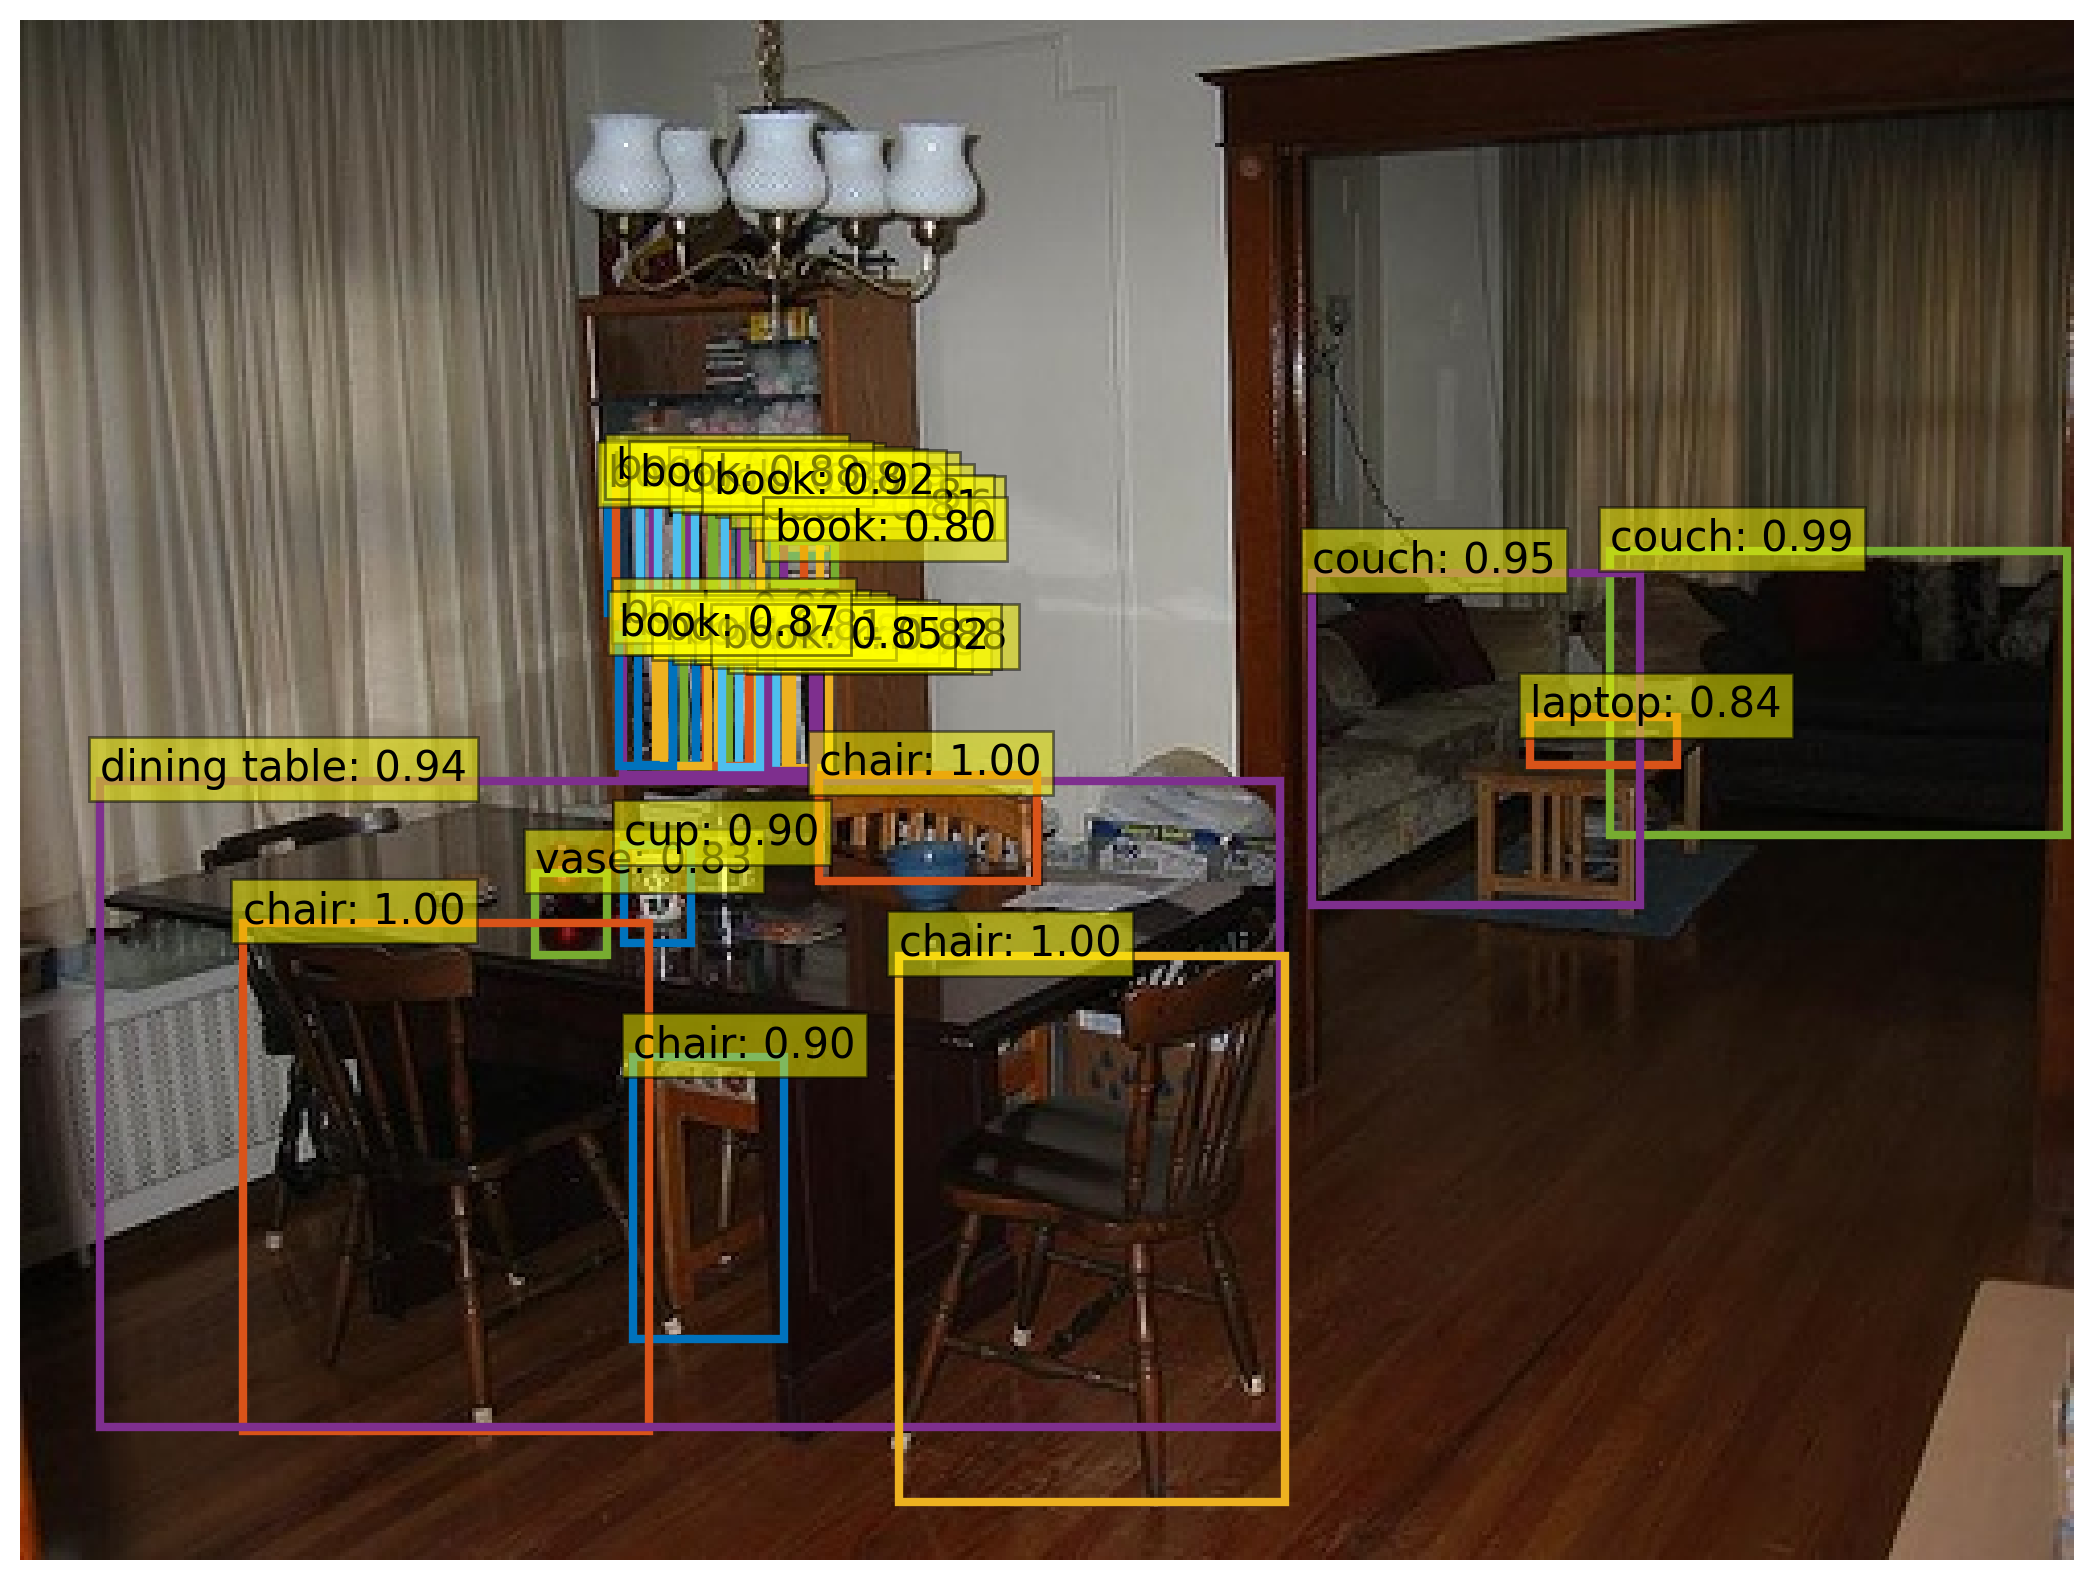

In [ ]:
url = '/content/VOC_coco_format/val2017/2007_005647.jpg'
im = Image.open(url)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

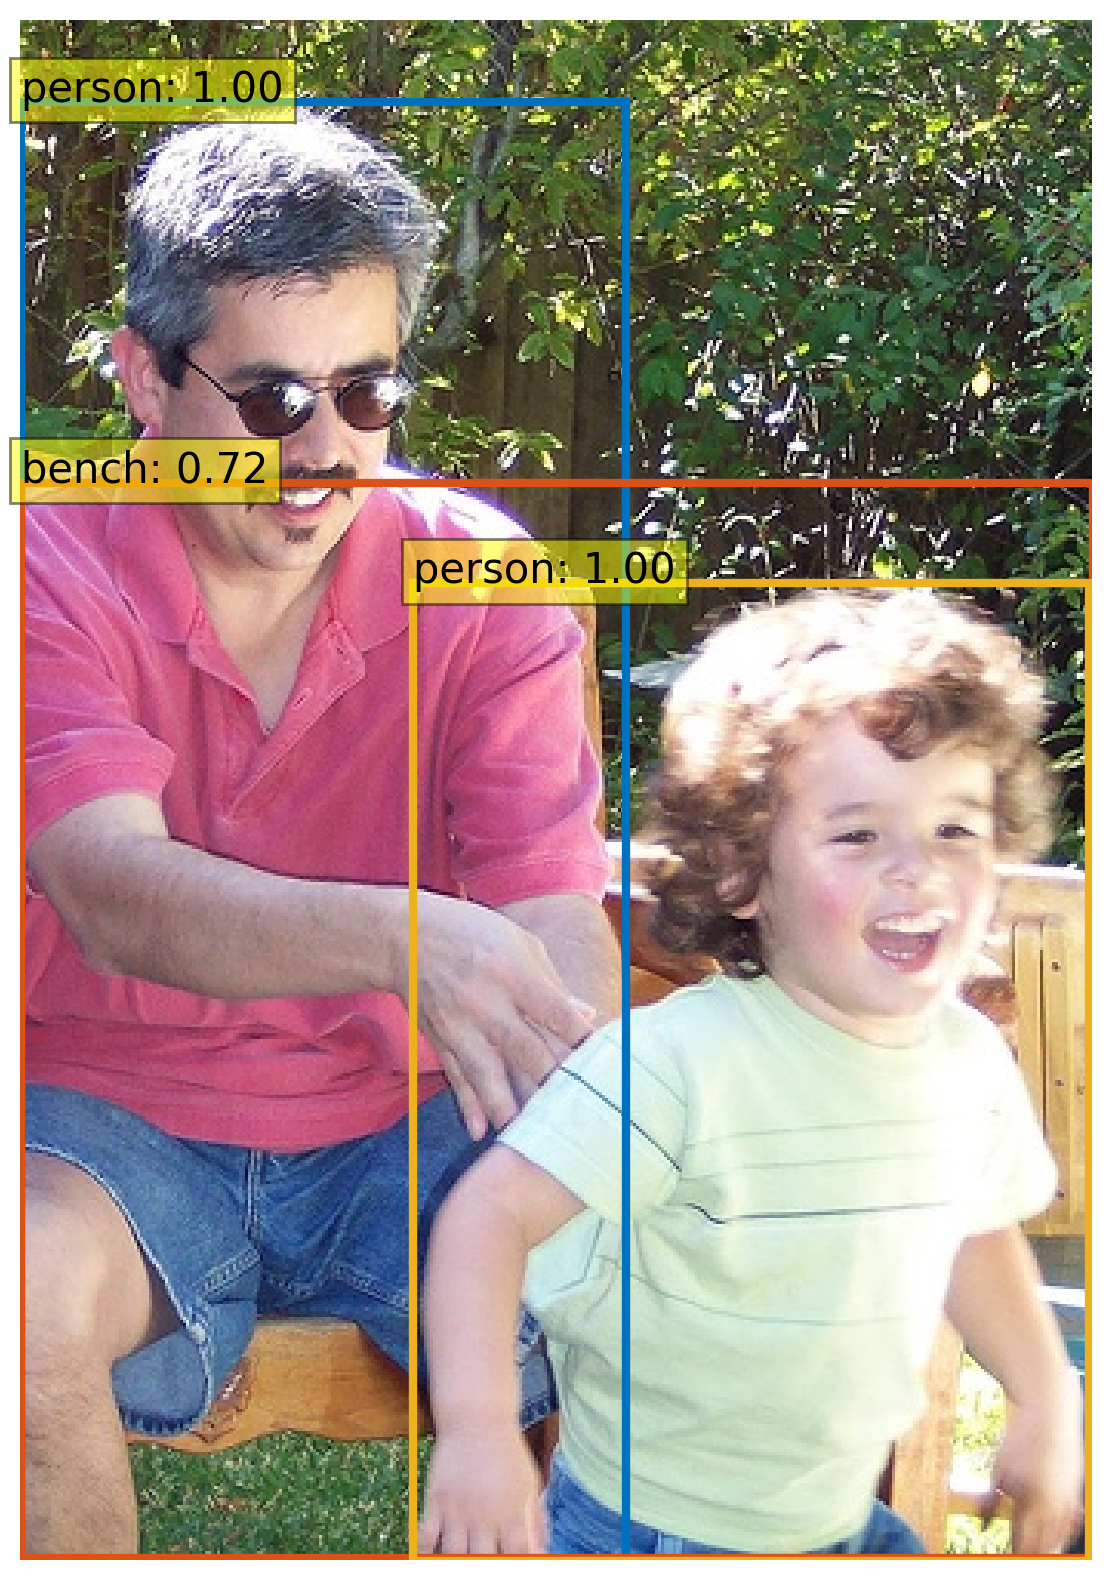

In [ ]:
url = '/content/VOC_coco_format/val2017/2007_006442.jpg'
im = Image.open(url)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

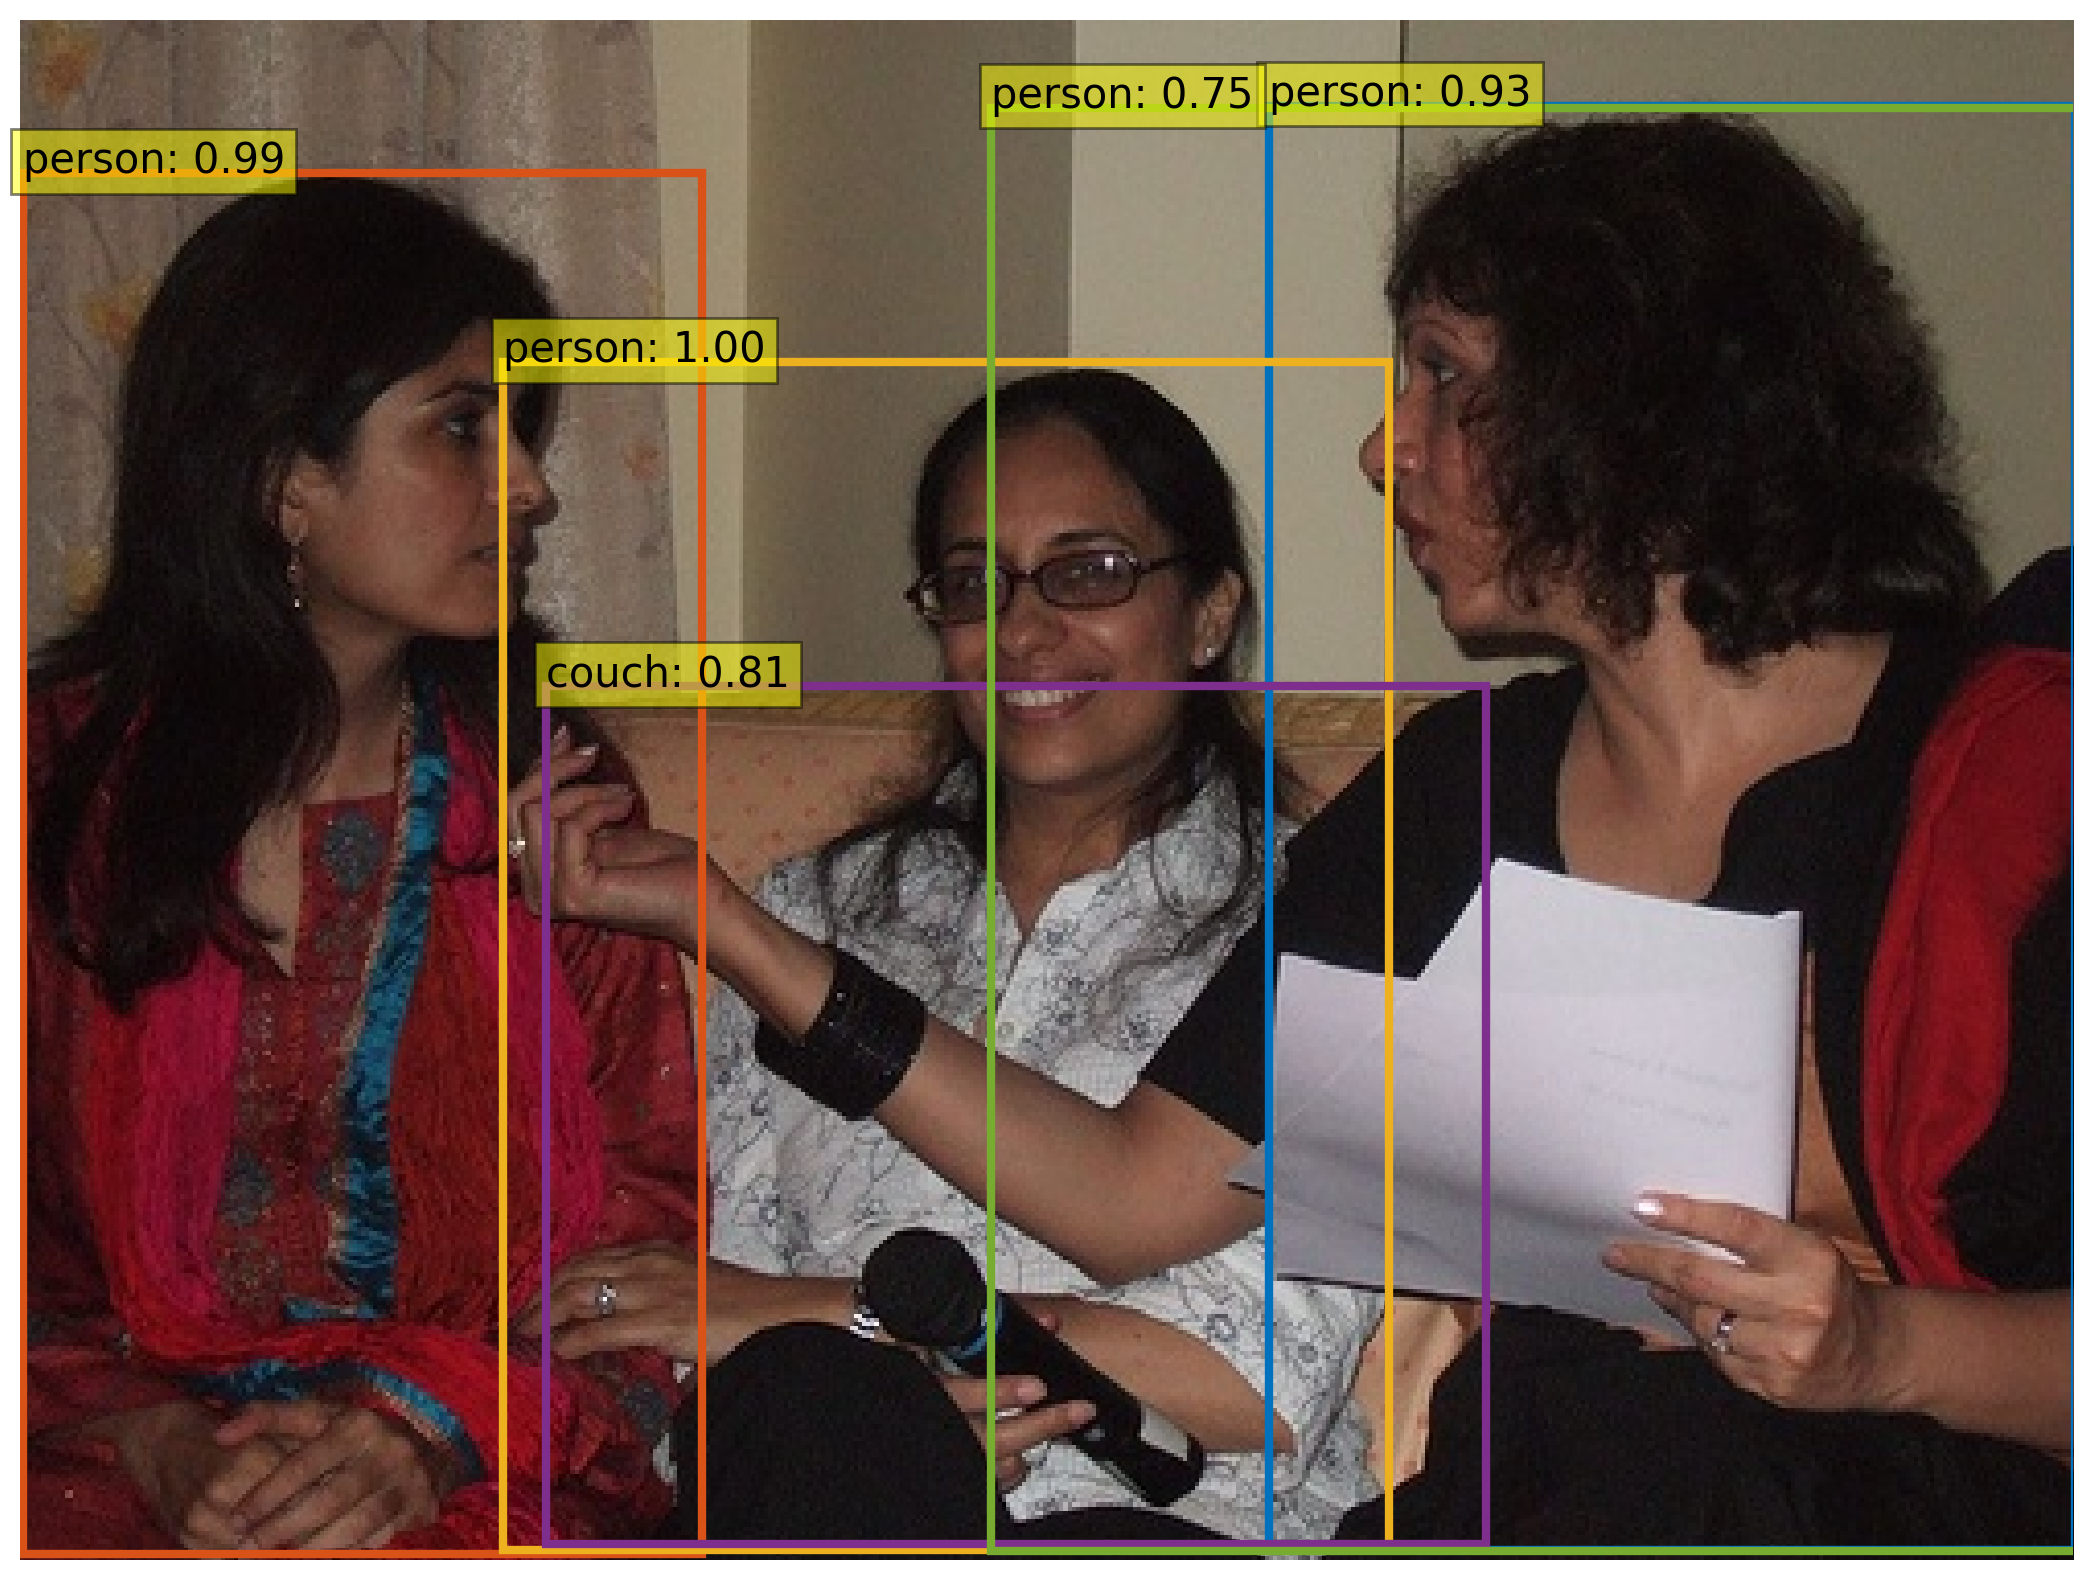

In [ ]:
url = '/content/VOC_coco_format/val2017/2007_009653.jpg'
im = Image.open(url)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)

# Evaluation metrics

In [ ]:
#@title Evaluation metrics of finetuned model
!python '/content/detr/main.py' --batch_size 4 --eval --no_aux_loss --resume '/content/output/checkpoint.pth' --coco_path '/content/VOC_coco_format'

Not using distributed mode
git:
  sha: 29901c51d7fe8712168b8d0d64351170bc0f83e0, status: has uncommited changes, branch: main

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=4, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=False, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco', coco_path='/content/VOC_coco_format', coco_panoptic_path=None, remove_difficult=False, output_dir='', device='cuda', seed=42, resume='/content/output/checkpoint.pth', start_epoch=0, eval=True, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The paramete

In [ ]:
#@title Evaluation metrics of pre trained model
!python '/content/detr/main.py' --batch_size 4 --eval --no_aux_loss --resume '/content/detr-r50-e632da11.pth' --coco_path '/content/VOC_coco_format'

Not using distributed mode
git:
  sha: 29901c51d7fe8712168b8d0d64351170bc0f83e0, status: clean, branch: main

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=4, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=False, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco', coco_path='/content/VOC_coco_format', coco_panoptic_path=None, remove_difficult=False, output_dir='', device='cuda', seed=42, resume='/content/detr-r50-e632da11.pth', start_epoch=0, eval=True, num_workers=2, world_size=1, dist_url='env://', distributed=False)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is